In [4]:
from ganrec_dataloader import * 
from utils import *    
energy = 11
z = 7.8880960e-2
pv = 1.04735263e-7
iter_num = 700
fname_data = 'data/gan_phase/data_spider.tif'

import torch
import skimage.io as io
import numpy as np
from utils import *
import sys
sys.stdout = open('prints.txt', 'w')

from utils import *
import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
from joblib import Parallel, delayed
from torchsummary import summary



args = {
        "path": "/asap3/petra3/gpfs/p05/2023/data/11016663//processed/thomas_001_d150/flat_corrected/rawBin2",
        "idx": 89,
        "energy_kev": 18.0,
        "detector_pixel_size": 2.57 * 1e-6,
        "distance_sample_detector": 0.15,
        "alpha": 1e-8,
        "delta_beta": 1,
        "pad": 1,
        "method": 'TIE',
        'iter_num': 500,
        'conv_num': 32,
        'conv_size': 3,
        'dropout': 0.25,
        'l1_ratio': 10,
        'abs_ratio': 1.0,
        'g_learning_rate': 1e-3,
        'd_learning_rate': 1e-5,
        'phase_only': False,
        'save_wpath': None,
        'init_wpath': None,
        'init_model': False,
        'recon_monitor': True,
        'seed': 42,
    }

def torch_reshape(image, complex = False):
    #if it's tensor and of shape 4, return the image
    if type(image) is torch.Tensor and len(image.shape) == 4:
        return image
    
    if type(image) is list:
        #use joblib to parallelize the process
        if len(image) > 30:
            n_jobs = 30
        # else:
        #     n_jobs = 5
            image = Parallel(n_jobs=n_jobs)(delayed(torch.from_numpy)(image[i]) for i in range(len(image)))
        else:
            image = [torch.from_numpy(image[i]) for i in range(len(image))]
        image = torch.stack(image)

    if type(image) is not torch.Tensor:
            image = torch.from_numpy(image)
    
    if len(image.shape) == 2:
        image = image.unsqueeze(0)
        image = image.unsqueeze(0)
    elif len(image.shape) == 3:
        image = image.unsqueeze(0)    
    elif len(image.shape) > 5:
        image = image.squeeze(1)
        print("Image shape not supported")
        return image
    
    #rearrange the dimension of the image [batch, channel, x, y]
    image = image.permute(1, 0, 2, 3)
    if complex:
        image = image.type(torch.complex64)
    else:
        image = image.float()
    return image

def torchnor_phase(image):
    image = torch_reshape(image)
    image = image - torch.min(image)
    if torch.max(image) != 0:
        image = image / torch.max(image)
    return image

def torch_contrast(image, contrast_factor = 0.02):
    if type(image) is not torch.Tensor:
        image = torch_reshape(image)
    image = transforms.functional.adjust_contrast(image, contrast_factor) 
    return image

def torch_brightness(image, brightness_factor = 0.02):
    image = torch_reshape(image)
    image = transforms.functional.adjust_brightness(image, brightness_factor)
    return image

def torch_detector(image):
    image = torch_reshape(image, complex = True)
    image = torch.abs(image)**2
    return image

def forward_propagate(shape_x, shape_y, pad, energy_kev, detector_pixel_size, distance_sample_detector, phase_image = None, attenuation_image = None, \
                    fresnel_factor  = None, wavefield = None, distance = None, **kwargs):
    if distance is not None:
        # fresnel_factor = fresnel_operator(shape_x, shape_y, detector_pixel_size, distance, lam.magnitude, pad)
        fresnel_factor = ffactor(shape_x*pad, shape_y*pad, energy_kev, distance, detector_pixel_size)
    if phase_image is None:
        if 'phase_image' in kwargs.keys():
            phase_image = kwargs['phase_image']
    if attenuation_image is None:
        if 'attenuation_image' in kwargs.keys():
            attenuation_image = kwargs['attenuation_image']

    if wavefield is None:
        if phase_image is None and attenuation_image is None:
            assert 'phase_image' in kwargs.keys() and 'attenuation_image' in kwargs.keys(), "phase_image and attenuation_image are not provided"
            phase_image = phase_image
            attenuation_image = attenuation_image

        if type(phase_image) is not list:
            phase_image = [phase_image]
        if type(attenuation_image) is not list:
            attenuation_image = [attenuation_image]
        
        if fresnel_factor is None:
            fresnel_factor = fresnel_factor

        if type(phase_image) is list and type(phase_image[0]) is torch.Tensor and len(phase_image[0].shape) == 4:
            phase_image = torch.stack(phase_image)
            attenuation_image = torch.stack(attenuation_image)
            #squeeze the first dimension
            if len(phase_image.shape) == 5:
                phase_image = phase_image.squeeze(0)
                attenuation_image = attenuation_image.squeeze(0)
        else:
            phase_image = torch_reshape(phase_image)
            attenuation_image = torch_reshape(attenuation_image)
        
        fresnel_factor = torch_reshape(fresnel_factor)
                
        # print("phase_image shape, attenuation_image shape, fresnel_factor shape", phase_image.shape, attenuation_image.shape, fresnel_factor.shape)
    
        odd_case = False
        px, py = phase_image.shape[2], phase_image.shape[3]
        if py % 2 != 0:
            phase_image = F.pad(phase_image, (0, 1, 0, 0), mode='constant', value=1)
            attenuation_image = F.pad(attenuation_image, (0, 1, 0, 0), mode='constant', value=1)
            odd_case = True
        if px % 2 != 0:
            phase_image = F.pad(phase_image, (0, 0, 0, 1), mode='constant', value=1)
            attenuation_image = F.pad(attenuation_image, (0, 0, 0, 1), mode='constant', value=1)
            odd_case = True
        if odd_case:
            new_px, new_py = phase_image.shape[2], phase_image.shape[3]
            if distance is None:
                distance = distance_sample_detector
            fresnel_factor = torch_reshape(ffactor(new_px*pad, new_py*pad, energy_kev, distance, detector_pixel_size))
            print("odd case", px, py, phase_image.shape, attenuation_image.shape, fresnel_factor.shape)
        
        # print("phase_image shape, attenuation_image shape, fresnel_factor shape", phase_image.shape, attenuation_image.shape, fresnel_factor.shape)
        
        
        #pad the phase and attenuation image to the same size as fresnel_factor by adding ones to the end of the image
        if fresnel_factor.shape != phase_image.shape:
            phase_image = F.pad(phase_image, (int((fresnel_factor.shape[3] - phase_image.shape[3])/2), int((fresnel_factor.shape[3] - phase_image.shape[3])/2), int((fresnel_factor.shape[2] - phase_image.shape[2])/2), int((fresnel_factor.shape[2] - phase_image.shape[2])/2)), mode='constant', value=1)
            attenuation_image = F.pad(attenuation_image, (int((fresnel_factor.shape[3] - attenuation_image.shape[3])/2), int((fresnel_factor.shape[3] - attenuation_image.shape[3])/2), int((fresnel_factor.shape[2] - attenuation_image.shape[2])/2), int((fresnel_factor.shape[2] - attenuation_image.shape[2])/2)), mode='constant', value=1)
        # print("phase_image shape, attenuation_image shape, fresnel_factor shape", phase_image.shape, attenuation_image.shape, fresnel_factor.shape)
        
        wavefield = torch.exp(torch.complex(-attenuation_image, phase_image))
    
    else:
        wavefield = torch_reshape(wavefield, complex = True)
        fresnel_factor = torch_reshape(fresnel_factor, complex = True)
        px2, py2 = wavefield.shape[2], wavefield.shape[3]
        px, py = fresnel_factor.shape[2], fresnel_factor.shape[3]
    I = (torch.abs(torch.fft.ifft2(fresnel_factor * torch.fft.fft2(wavefield)))**2).type(torch.float32)
    I = I[:, :, int((I.shape[2] - shape_x)/2):int((I.shape[2] + shape_x)/2), int((I.shape[3] - shape_y)/2):int((I.shape[3] + shape_y)/2)]
    I = torch_reshape(I)
    prop_intensity = I
    fresnel_factor = fresnel_factor.detach().cpu().numpy()[0,0,:,:]
    phase_image = phase_image.detach().cpu().numpy()[0,0,:,:]
    attenuation_image = attenuation_image.detach().cpu().numpy()[0,0,:,:]
    return I
    


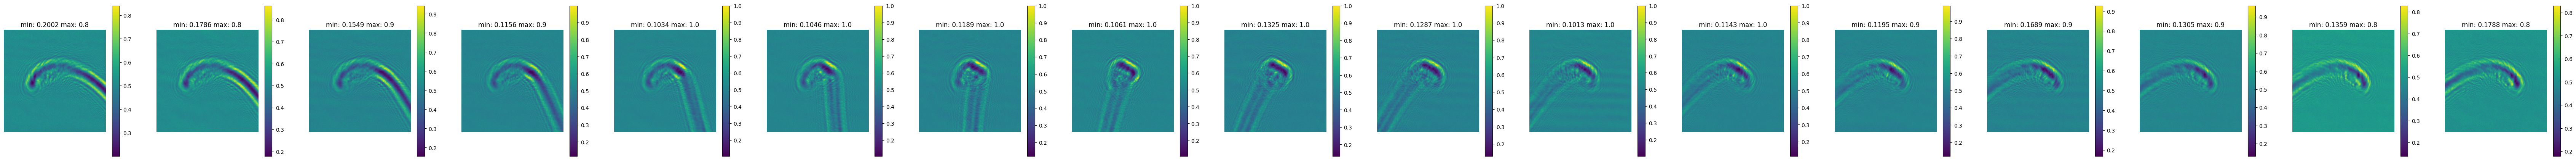

In [11]:
energy = 11
z = 7.8880960e-2
pv = 1.04735263e-7
iter_num = 700
fname_data = 'data/gan_phase/data_spider.tif'

info = {
    'path': None,
    'images': io.imread(fname_data),
    'idx': list(np.arange(0, 170, 10)),
    'energy_kev': energy,
    'detector_pixel_size': pv,
    'distance_sample_detector': z,
    'pad': 1,
    'alpha': 1e-8,
    'iter_num': 100,
    'init_model': False,
    'transform_type': 'brightness',
    'transform_factor': 0.5,
    'file_type': 'tif',
}
args.update(info)
dataloader = Ganrec_Dataloader(**args)
dataloader.visualize(tranformed=True, show_or_plot='show')

In [16]:
def ffactors(px, py, energy, zs, pv):
    lambda_p = 1.23984122e-09 / energy
    frequ_prefactors = [2 * np.pi  * lambda_p * zs[i] / pv ** 2 for i in range(len(zs))]
    freq_x = fftfreq(px)
    freq_y = fftfreq(py)
    xi, eta = np.meshgrid(freq_x, freq_y)
    xi = xi.astype('float32')
    eta = eta.astype('float32')
    h = [((np.exp(- 1j * frequ_prefactors[i] * (xi ** 2 + eta ** 2) / 2)).T).astype('complex64') for i in range(len(zs))]
    return h

def forward_propagate(shape_x = None, shape_y = None, pad = 2, energy_kev = None, detector_pixel_size = None, distance_sample_detector = None, phase_image = None, attenuation_image = None, fresnel_factor  = None, wavefield = None, distance = None, **kwargs):
    assert phase_image is not None or attenuation_image is not None, "phase_image and attenuation_image are not provided"
    if fresnel_factor is None:
        if distance is None:
            distance = distance_sample_detector
        fresnel_factor = ffactor(shape_x*pad, shape_y*pad, energy_kev, distance, detector_pixel_size) if type(distance) is not list else ffactors(shape_x*pad, shape_y*pad, energy_kev, distance, detector_pixel_size)
        print("fresnel_factor shape", fresnel_factor.shape) if type(distance) is not list else print("fresnel_factor shape", fresnel_factor[0].shape)
    if wavefield is None:
        if phase_image is None and attenuation_image is None:
            assert 'phase_image' in kwargs.keys() and 'attenuation_image' in kwargs.keys(), "phase_image and attenuation_image are not provided"
            phase_image = phase_image
            attenuation_image = attenuation_image

        if type(phase_image) is not list:
            phase_image = [phase_image]
        if type(attenuation_image) is not list:
            attenuation_image = [attenuation_image]

        if type(phase_image) is list and type(phase_image[0]) is torch.Tensor and len(phase_image[0].shape) == 4:
            phase_image = torch.stack(phase_image)
            attenuation_image = torch.stack(attenuation_image)
            #squeeze the first dimension
            if len(phase_image.shape) == 5:
                phase_image = phase_image.squeeze(0)
                attenuation_image = attenuation_image.squeeze(0)
        else:
            phase_image = torch_reshape(phase_image)
            attenuation_image = torch_reshape(attenuation_image)
        
        fresnel_factor = torch_reshape(fresnel_factor)
                
        # print("phase_image shape, attenuation_image shape, fresnel_factor shape", phase_image.shape, attenuation_image.shape, fresnel_factor.shape)
    
        odd_case = False
        px, py = phase_image.shape[2], phase_image.shape[3]
        if py % 2 != 0:
            phase_image = F.pad(phase_image, (0, 1, 0, 0), mode='constant', value=1)
            attenuation_image = F.pad(attenuation_image, (0, 1, 0, 0), mode='constant', value=1)
            odd_case = True
        if px % 2 != 0:
            phase_image = F.pad(phase_image, (0, 0, 0, 1), mode='constant', value=1)
            attenuation_image = F.pad(attenuation_image, (0, 0, 0, 1), mode='constant', value=1)
            odd_case = True
        if odd_case:
            new_px, new_py = phase_image.shape[2], phase_image.shape[3]
            if distance is None:
                distance = distance_sample_detector
            fresnel_factor = torch_reshape(ffactor(new_px*pad, new_py*pad, energy_kev, distance, detector_pixel_size)) if type(distance) is not list else torch_reshape(ffactors(new_px*pad, new_py*pad, energy_kev, distance, detector_pixel_size))
            
            print("odd case", px, py, phase_image.shape, attenuation_image.shape, fresnel_factor.shape)
        
        # print("phase_image shape, attenuation_image shape, fresnel_factor shape", phase_image.shape, attenuation_image.shape, fresnel_factor.shape)
        
        
        #pad the phase and attenuation image to the same size as fresnel_factor by adding ones to the end of the image
        if type(fresnel_factor) is not list and fresnel_factor.shape != phase_image.shape or type(fresnel_factor) is list and fresnel_factor[0].shape != phase_image.shape:
            phase_image = F.pad(phase_image, (int((fresnel_factor.shape[3] - phase_image.shape[3])/2), int((fresnel_factor.shape[3] - phase_image.shape[3])/2), int((fresnel_factor.shape[2] - phase_image.shape[2])/2), int((fresnel_factor.shape[2] - phase_image.shape[2])/2)), mode='constant', value=1)
            attenuation_image = F.pad(attenuation_image, (int((fresnel_factor.shape[3] - attenuation_image.shape[3])/2), int((fresnel_factor.shape[3] - attenuation_image.shape[3])/2), int((fresnel_factor.shape[2] - attenuation_image.shape[2])/2), int((fresnel_factor.shape[2] - attenuation_image.shape[2])/2)), mode='constant', value=1)
        # print("phase_image shape, attenuation_image shape, fresnel_factor shape", phase_image.shape, attenuation_image.shape, fresnel_factor.shape)
        
        wavefield = torch.exp(torch.complex(-attenuation_image, phase_image))
    
    else:
        wavefield = torch_reshape(wavefield, complex = True)
        fresnel_factor = torch_reshape(fresnel_factor, complex = True)
        px, py = fresnel_factor.shape[2], fresnel_factor.shape[3]
    I = (torch.abs(torch.fft.ifft2(fresnel_factor * torch.fft.fft2(wavefield)))**2).type(torch.float32)
    I = I[:, :, int((I.shape[2] - shape_x)/2):int((I.shape[2] + shape_x)/2), int((I.shape[3] - shape_y)/2):int((I.shape[3] + shape_y)/2)]
    I = torch_reshape(I)
    fresnel_factor = fresnel_factor.detach().cpu().numpy()[0,0,:,:]
    phase_image = phase_image.detach().cpu().numpy()[0,0,:,:]
    attenuation_image = attenuation_image.detach().cpu().numpy()[0,0,:,:]
    return I
    

def get_all_info(path = None, images = None, idx = 1000, energy_kev = 18.0, detector_pixel_size = 2.57 * 1e-6, distance_sample_detector = 0.15, alpha = 1e-8, delta_beta = 1e1, pad = 1, method = 'TIE', file_type = 'tif', image = None, **kwargs):
    """
    make sure that the unit of energy is in keV, the unit of detector_pixel_size is in meter, and the unit of distance_sample_detector is in meter
    """
    if idx is not None and type(idx) is not list:
        idx = [idx]
    
    if images is not None:
        image = [images[i] for i in idx]
    
    if 'image_path' in kwargs.keys():
        image_path = kwargs['image_path']
    else:
        image_path = None

    phase = None if 'phase' not in kwargs.keys() else kwargs['phase']
    attenuation = None if 'attenuation' not in kwargs.keys() else kwargs['attenuation']    
        
    if path is not None:
        
        #if path is a folder
        if type(path) is str and os.path.isdir(path):
            images = list(io.imread_collection(path + '/*.' + file_type).files)
            image_path = [images[i] for i in idx]
            image = load_images_parallel(image_path)
        #if path is a list of files
        elif type(path) is list and not os.path.isfile(path[0]):
            image_path = [path[i] for i in idx]
            image = load_images_parallel(image_path)
        elif type(path) is list and os.path.isdir(path[0]):
            folders = path
            images = []
            for folder in folders:
                images += list(io.imread_collection(folder + '/*.' + file_type).files)
            image_path = [images[i] for i in idx]
            image = load_images_parallel(image_path)
        elif type(path) is np.array:
            image_path = os.getcwd()
            images = path
            image = [images[i] for i in idx]
        else:
            image = [path[i] for i in idx]
            try:
                image = load_images_parallel(image)
            except:
                pass
                
    else:
        phase = None if 'phase' not in kwargs.keys() else kwargs['phase']
        attenuation = None if 'attenuation' not in kwargs.keys() else kwargs['attenuation']
        if phase is not None and attenuation is not None:
            phase = np.zeros((attenuation.shape[0], attenuation.shape[1])) if phase is None and attenuation is not None else phase
            attenuation = np.zeros((phase.shape[0], phase.shape[1])) if attenuation is None and phase is not None else attenuation
            print("phase shape", phase.shape)
            shape_x, shape_y = phase.shape
            fresnel_factor = ffactor(shape_x*pad, shape_y*pad, energy_kev, distance_sample_detector, detector_pixel_size)
            image = forward_propagate(shape_x, shape_y, pad, energy_kev, detector_pixel_size, distance_sample_detector, phase_image = phase, attenuation_image = attenuation, fresnel_factor = fresnel_factor)[0,0,:,:].numpy()
    
    if image is not None: 
        if type(image) is list:
            ND = len(image)
            if len(image[0].shape) == 2:
                shape_x, shape_y = image[0].shape
                Fx, Fy = grid_generator(shape_x, shape_y, upscale=pad, ps = detector_pixel_size)
                ND = 1
                image_path = os.getcwd()
            else:
                shape_x, shape_y = image[0].shape[1:]
                Fx, Fy = grid_generator(shape_x, shape_y, upscale=pad, ps = detector_pixel_size)
        else:
            ND = 1
            shape_x, shape_y = image.shape
            Fx, Fy = grid_generator(shape_x, shape_y, upscale=pad, ps = detector_pixel_size)
        if image_path is None:
            image_path = os.getcwd()
        if images is None:
            images = image

        if 'correct' in kwargs.keys():
            if kwargs['correct'] == True:
                if 'mean_dark_image' and 'mean_ref_image' in kwargs.keys():
                    mean_dark_image = kwargs['mean_dark_image']
                    mean_ref_image = kwargs['mean_ref_image']
                else: 
                    all_images = list(io.imread_collection(path + '/*.' + file_type).files)
                    mean_ref_image = np.mean(io.imread_collection([im_name for im_name in all_images if 'ref' in im_name]), axis = 0)
                    mean_dark_image = np.mean(io.imread_collection([im_name for im_name in all_images if 'dar' in im_name]), axis = 0)
                    
                if len(image) > 1:
                    image = [(image[i] - mean_dark_image) / (mean_ref_image - mean_dark_image) for i in range(len(image))]
                else:
                    image = (image - mean_dark_image) / (mean_ref_image - mean_dark_image)
        
        ff = ffactor(shape_x*pad, shape_y*pad, energy_kev, distance_sample_detector, detector_pixel_size)
        kwargs = {
            "path": path,
            "output_path" : os.getcwd(),
            "idx": idx,
            "column_name": 'path',
            "energy_J": energy_kev_to_joule(energy_kev),
            "energy_kev": energy_kev,
            "lam": wavelength_from_energy(energy_kev),
            "detector_pixel_size": detector_pixel_size,
            "distance_sample_detector": distance_sample_detector,
            "fresnel_number": fresnel_calculator(energy_kev = energy_kev, detector_pixel_size = detector_pixel_size, distance_sample_detector = distance_sample_detector),
            "wave_number": wave_number(energy_kev),

            "shape_x": shape_x,
            "px": shape_x,
            "shape_y": shape_y,
            "py": shape_y,
            "pad_mode": 'symmetric',
            'shape': [int(shape_x), int(shape_y)],
            'nx': int(shape_x), 'ny': int(shape_y),
            'distance': [distance_sample_detector],
            'z': distance_sample_detector,
            
            'energy': energy_kev, 
            'alpha': alpha, 
            'pad': pad,
            'nfx': int(shape_x) * pad, 
            'nfy': int(shape_y) * pad,
            'pv': detector_pixel_size,
            'pixel_size': [detector_pixel_size, detector_pixel_size],
            'sample_frequency': [1.0/detector_pixel_size, 1.0/detector_pixel_size],
            'fx': Fx, 'fy': Fy,
            'method': method, 
            'delta_beta': delta_beta,
            "fresnel_factor":  ffactor(shape_x*pad, shape_y*pad, energy_kev, distance_sample_detector, detector_pixel_size),
            "i_input": image[0],
            "image_path": image_path,
            "image": image,
            "all_images": images,
            "ND": ND,
            "fresnel_factor": ff,
            "phase": phase,
            "attenuation": attenuation,
        } 
        kwargs.update(save_path_generator(**kwargs))
        return kwargs

    else:
        
        assert path is not None
        if type(path) is str:
            assert os.path.exists(path), "path does not exist"
            if os.path.isdir(path):
                images = list(io.imread_collection(path + '/*.' + file_type).files)
                image_path = [images[i] for i in idx]
                image = load_images_parallel(image_path)
            else:
                images = list(path)
                image = load_image(path)
            get_all_info(image=image, **kwargs)
        elif type(path) is list:
            path = [path[i] for i in idx]
            if type(path[0]) is str:
                #if the path[0] is a folder
                if os.path.isdir(path[0]):
                    images = list(io.imread_collection(path + '/*.' + file_type).files)
                    image_path = [images[i] for i in idx]
                else:
                    image_path = path
                image = load_images_parallel(image_path)
            else:
                image = [path[i] for i in idx]
            get_all_info(image=image, **kwargs)
        else:
            images = path
            image = [images[i] for i in idx]
            get_all_info(image=image, **kwargs)

class Ganrec_Dataloader(torch.utils.data.Dataset):
    def __init__(self,**kwargs):
        self.kwargs = kwargs
        self.kwargs.update(get_all_info(**kwargs))
        keys = self.kwargs.keys()
        [self.__setattr__(key, self.kwargs[key]) for key in keys]
        self.dims = (self.ND, self.shape_x, self.shape_y)
        if self.kwargs['transform_type'] == 'reshape':
            self.transformed_images = torch_reshape(self.image)
        elif self.kwargs['transform_type'] == 'normalize':
            self.transformed_images = torchnor_phase(self.image)
        elif self.kwargs['transform_type'] == 'contrast':
            self.transformed_images = torch_reshape(self.image)
            self.transformed_images = torch_contrast(self.transformed_images, kwargs['transform_factor'])
        elif self.kwargs['transform_type'] == 'contrast_normalize':
            self.transformed_images = torch_reshape(self.image)
            self.transformed_images = torch_contrast(self.transformed_images, kwargs['transform_factor'])
            self.transformed_images = torchnor_phase(self.transformed_images)
        elif self.kwargs['transform_type'] == 'brightness':
            self.transformed_images = torch_reshape(self.image)
            self.transformed_images = torch_brightness(self.transformed_images,  kwargs['transform_factor'])
            
        else:
            self.transformed_images = torch_reshape(self.image)
    
        self.batch_size = self.transformed_images.shape[0]
        super(Ganrec_Dataloader, self).__init__()

    def __len__(self):
        return len(self.image_path)
    
    def __getitem__(self, idx = None, transform_type = None): 
            
        if idx is not None:
            kwargs = self.kwargs
            if transform_type is not None:
                kwargs['transform_type'] = transform_type
            kwargs["idx"] = idx
            new = Ganrec_Dataloader(**kwargs)
            return new.transformed_images
        else:
            return self.transformed_images
    
    def __getbatchimages__(self, batch_size = None, transform_type = None):
        """
        Returns a batch of transformed images:
        ********************************
        batch_images, idx_batches = dataloader.__getbatchimages__(batch_size = 100, transform_type = 'reshape')
        for i, image in enumerate(batch_images):
            print(image.shape)
        ********************************
        """
        if batch_size is None:
            batch_size = self.batch_size
        if transform_type is None:
            transform_type = self.kwargs['transform_type']
        all_images = self.all_images
        n = len(all_images)
        seed = self.seed
        import random
        random.seed(seed)
        all_idx = list(range(n))
        random.shuffle(all_idx)
        idx_batches = [all_idx[i:i + batch_size] for i in range(0, n, batch_size)]
        batch_images = []
        from joblib import Parallel, delayed
        n_jobs = max(30, len(idx_batches))
        batch_images = Parallel(n_jobs=n_jobs)(delayed(self.__getitem__)(idx, transform_type) for idx in idx_batches)
        return batch_images, idx_batches
    
        
    def normalize(self, idx = None, transform_type = None):
        image = self.__getitem__(idx, transform_type)
        # image = torchnor_phase(image)
        return image
    
    def get_kwargs(self):
        return self.__dict__
    
    def visualize(self, idx = None, random = False, show_or_plot = 'show', tranformed = False):
        if idx is not None:
            kwargs = self.kwargs
            kwargs["idx"] = idx
            new = Ganrec_Dataloader(**kwargs)
        else:
            new = self
        if tranformed:
            images = new.transformed_images
            try:
                images = images[:,0,:,:].detach().cpu().numpy()
            except:
                images = images[0,:,:].numpy()
        else:
            images = new.image

        if type(images) is not list:
            # images = [images]
            images = list(images)
        rows = int(np.sqrt(len(images)))
        if rows ==1:
            cols = len(images)
        else:
            cols = rows + 1
        visualize(images, rows=rows, cols = cols, random=random, show_or_plot = show_or_plot)
    
    def forward_propagate(self, distance = None):
        distance = self.distance_sample_detector if distance is None else distance
        wavefield = None if 'wavefield' not in self.kwargs.keys() else self.kwargs['wavefield']
        print(distance)

        if type(distance) is not list:
            self.propagated_forward = forward_propagate(shape_x = self.shape_x, shape_y = self.shape_y, pad = self.pad, energy_kev = self.energy_kev, detector_pixel_size = self.detector_pixel_size, distance_sample_detector = distance, phase_image = self.phase, attenuation_image = self.attenuation, fresnel_factor  = self.fresnel_factor, wavefield = wavefield, distance = distance)
        else:
            propagated_forward = [forward_propagate(shape_x = self.shape_x, shape_y = self.shape_y, pad = self.pad, energy_kev = self.energy_kev, detector_pixel_size = self.detector_pixel_size, distance_sample_detector = distance[i], phase_image = self.phase, attenuation_image = self.attenuation, fresnel_factor  = None, wavefield = wavefield, distance = distance[i]) for i in range(len(distance))]
            self.propagated_forward = torch.stack(propagated_forward, dim = 0)[:,0,:,:,:]
            print(self.propagated_forward.shape)
        return self.propagated_forward



# propagation of shepp-logan and cameraman images

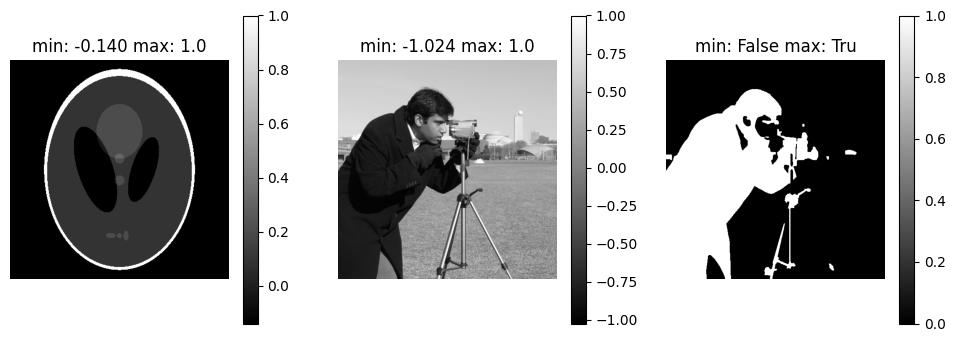

In [12]:
from skimage.data import shepp_logan_phantom, camera
from skimage.transform import resize
import quantities as pq
# from utils import segment

shepp_logan_image = (nor_phase(shepp_logan_phantom()))/(np.max(nor_phase(shepp_logan_phantom())))
camera_image = nor_phase(camera())/np.max(nor_phase(camera()))
visualize([shepp_logan_image, camera_image, segment(camera(), type = 'chan_vese')[0]])

phase_image = camera_image
attenuation_image = shepp_logan_image

px, py = phase_image.shape
attenuation_image = resize(attenuation_image, (px, py))

energy = 30.8 * pq.keV
lam = wavelength_from_energy(energy)
fresnel_nummber = 0.005 * pq.dimensionless
z = 1.0 * pq.meter
pv = np.sqrt(fresnel_nummber * lam * z) #array(8.39314161e-06) * m
px, py = phase_image.shape

kwargs = {
    'experiment_name': 'cameraman_with_shepplogan',
    'iter_num': 300,
    'internal_iter': 3,
    'last_retrieval': False,
    'save_wpath': 'data/gan_phase/spheres/',
    'init_wpath': 'data/gan_phase/spheres/',
    'init_model': False,
    'save_model': False,
    'filter_type': 'median', #chose from median, contrast, noise, diffuse, phase_only, alternate
    'output_num': 2,
    'phase_only': False,
    'recon_monitor': True,
}

kwargs.update({
    'energy': energy.magnitude,
    'z': z.magnitude,
    'pv': pv.magnitude,
    'idx': 0,
    'abs_ratio': 0.5,
    'px': px,
    'py': py,
})

given_phase = phase_image
cos, sin = np.cos(given_phase), np.sin(given_phase)
given_absorption = (1 - attenuation_image) * kwargs['abs_ratio']
given_absorption = resize(given_absorption, (px, py))

different_distances = list(np.arange(0, kwargs['z'] * 5 + 0.3, 0.3))
ffs = ffactors(px, py, kwargs['energy'], different_distances, kwargs['pv'])
# propagated_images = [torchnor_phase(FresnelPropagator(given_phase, given_absorption, ffs[i])) for i in range(len(ffs))]
# visualize([propagated_images[1][0,0,:,:].numpy(), propagated_images[10][0,0,:,:].numpy(), segment(propagated_images[-1][0,0,:,:].numpy(), type = 'chan_vese')[1]])



In [17]:
kwargs['path'] = None
kwargs['phase'] = given_phase
kwargs['attenuation'] = given_absorption
kwargs['distance'] = None
pad = 5
kwargs['idx'] = 0
different_distances = list(np.arange(0, kwargs['z'] * 5 + 0.3, 0.3))
ffs = ffactors(px * pad, py *pad, kwargs['energy'], different_distances, kwargs['pv'])
kwargs['fresnel_factor'] = ffs[-1]
kwargs['wavefield'] = None
kwargs['pad'] = pad
kwargs['shape_x'] = px
kwargs['shape_y'] = py 
kwargs['detector_pixel_size'] = kwargs['pv']
kwargs['energy_kev'] = kwargs['energy']
kwargs['distance_sample_detector'] = kwargs['z']
kwargs['phase_only'] = False
info = {
    'path': None,
    'images': None,
    'idx': 0,
    'energy_kev': kwargs['energy'],
    'detector_pixel_size': kwargs['pv'],
    'distance_sample_detector': kwargs['z'],
    'pad': pad,
    'alpha': 1e-8,
    'iter_num': 100,
    'init_model': False,
    'transform_type': 'brightness',
    'transform_factor': 0.5,
    'file_type': 'tif',
    'phase': given_phase,
    'attenuation': given_absorption,
    'distance': different_distances,
}
ganrec = Ganrec_Dataloader(**info)
ganrec.kwargs
ganrec.forward_propagate(different_distances)

# propagated_images =torchnor_phase(forward_propagate(**kwargs))
# visualize([propagated_images[0,0,:,:].numpy(), propagated_images[0,0,:,:].numpy(), segment(propagated_images[0,0,:,:].numpy(), type = 'chan_vese')[0]])
# visualize([propagated_images[1][0,0,:,:].numpy(), propagated_images[10][0,0,:,:].numpy(), segment(propagated_images[-1][0,0,:,:].numpy(), type = 'chan_vese')[1]])


tensor([[[[0.3197, 0.3197, 0.3197,  ..., 0.3197, 0.3197, 0.3197],
          [0.3197, 0.3197, 0.3197,  ..., 0.3197, 0.3197, 0.3197],
          [0.3197, 0.3197, 0.3197,  ..., 0.3197, 0.3197, 0.3197],
          ...,
          [0.3197, 0.3197, 0.3197,  ..., 0.3197, 0.3197, 0.3197],
          [0.3197, 0.3197, 0.3197,  ..., 0.3197, 0.3197, 0.3197],
          [0.3197, 0.3197, 0.3197,  ..., 0.3197, 0.3197, 0.3197]]],


        [[[0.1735, 0.1807, 0.1900,  ..., 0.1864, 0.1776, 0.1700],
          [0.1808, 0.1893, 0.1995,  ..., 0.1965, 0.1861, 0.1779],
          [0.1899, 0.1997, 0.2115,  ..., 0.2081, 0.1963, 0.1867],
          ...,
          [0.0754, 0.0793, 0.0911,  ..., 0.1812, 0.1551, 0.1315],
          [0.0722, 0.0741, 0.0792,  ..., 0.1558, 0.1391, 0.1485],
          [0.0739, 0.0726, 0.0747,  ..., 0.1473, 0.1436, 0.1408]]],


        [[[0.1712, 0.1766, 0.1822,  ..., 0.1789, 0.1735, 0.1685],
          [0.1763, 0.1818, 0.1877,  ..., 0.1844, 0.1784, 0.1737],
          [0.1821, 0.1880, 0.1943,  ..

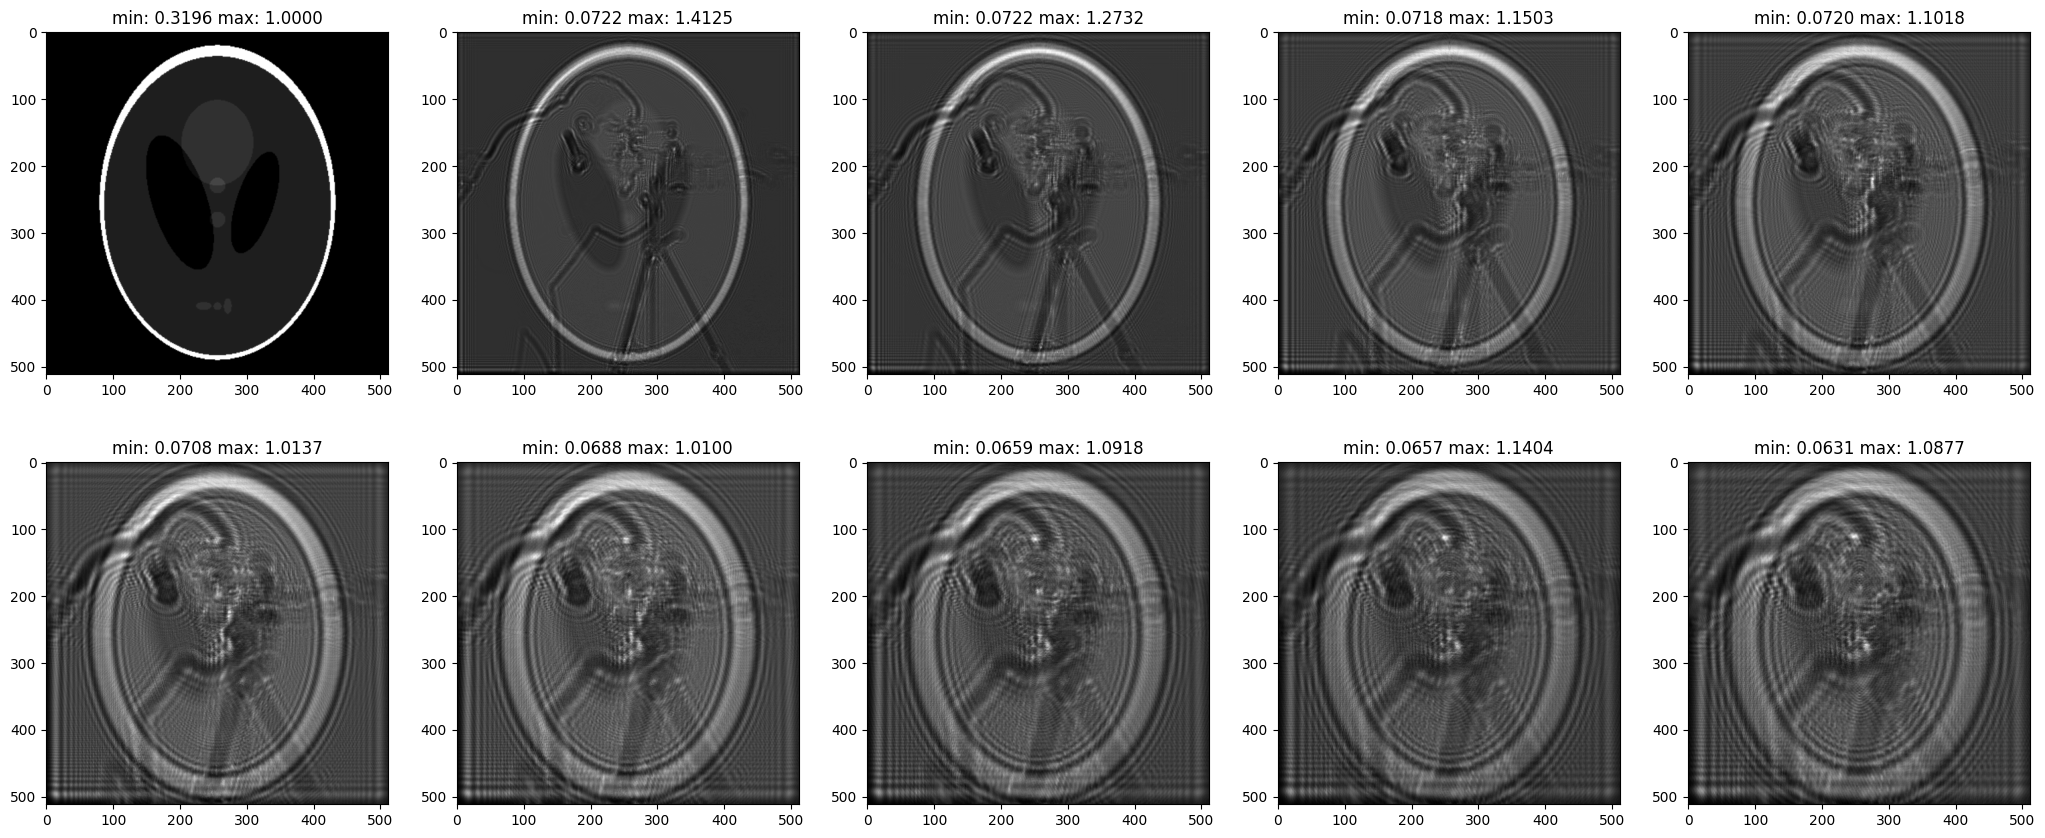

In [19]:
visualize(list(ganrec.propagated_forward[:,0,:,:].detach().cpu().numpy()), rows = 2, cols = 5, random = False, show_or_plot = 'show')

# Running GANPhase for two datas

> #### <u> 1. Projection of phantom object at P05 - 18 KEV </u>

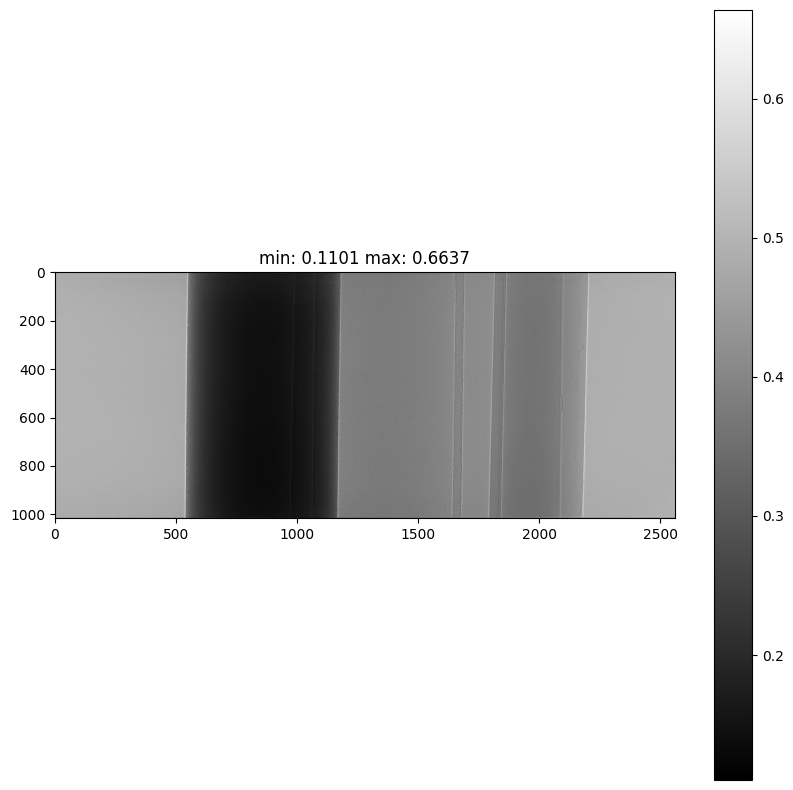

In [36]:
path = "/asap3/petra3/gpfs/p05/2023/data/11016663//processed/thomas_001_d150/flat_corrected/rawBin2"
infos = {
    'path' : path,
    'images' : None,
    'idx' : 50,
    'energy_kev' : 18.0,
    'detector_pixel_size' : 2.57 * 1e-6,
    'distance_sample_detector' :0.15,
    'pad':5,
    'alpha': 1e-8,
    'iter_num': 100,
    'init_model': False,
    'transform_type': 'brightness',
    'transform_factor': 0.5,
    'phase_image': None,
    'attenuation_image': None,
    'file_type': 'tif',
}

ganrec = Ganrec_Dataloader(**infos)
ganrec.visualize(tranformed=True, show_or_plot='show')

In [37]:
ganrec.fresnel_factor.shape

(12800, 5075)